# My dataset + BERTu 70/30

In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [6]:
# Basic text preprocessing
def preprocess_text(text):
    # Remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert to lower case
    text = text.lower()
    # Remove tags
    text = re.sub("<.*?>", " ", text)
    # Remove special characters and digits
    text = re.sub(r"(\d|\W)+", " ", text)
    return text

# Load data
data_path = '../data/SentimentAnalysisMaltese.xlsx'
data = pd.read_excel(data_path)

# Map labels to integers
label_map = {'Positive': 1, 'Negative': 0}
data['SENTIMENT'] = data['SENTIMENT'].map(label_map)

# Apply preprocessing to text data
data['TEXT'] = data['TEXT'].apply(preprocess_text)

# Initialize tokenizer from BERTu
tokenizer = AutoTokenizer.from_pretrained('MLRS/BERTu')

# Tokenize data
inputs = tokenizer(data['TEXT'].tolist(), max_length=512, padding='max_length', truncation=True, return_tensors='pt')
attention_masks = inputs['attention_mask']  # Attention masks

# Split data into train and test
train_inputs, test_inputs, train_masks, test_masks, train_labels, test_labels = train_test_split(
    inputs['input_ids'], attention_masks, data['SENTIMENT'], test_size=0.3, random_state=42
)

# Convert labels to tensors
train_labels = torch.tensor(train_labels.to_numpy()).long()
test_labels = torch.tensor(test_labels.to_numpy()).long()

# Create TensorDatasets
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [7]:
# Initialize BERTu model
model = AutoModelForSequenceClassification.from_pretrained('MLRS/BERTu', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at MLRS/BERTu and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [8]:
# Optimization and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*3)

# Training loop
model.train()
for epoch in range(3):  # Number of epochs
    for batch in train_loader:
        batch = [item.to(device) for item in batch]  # Ensure all tensors are on the correct device
        inputs, masks, labels = batch
        model.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

c:\Users\Isaac\anaconda3\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [11]:
# Evaluation loop
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = [item.to(device) for item in batch]
        inputs, masks, labels = batch
        outputs = model(inputs, attention_mask=masks)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).tolist())
        true_labels.extend(labels.tolist())

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions, target_names=['Negative', 'Positive'], output_dict=True)

print(f"Accuracy: {accuracy:.2f}")
print("Metrics for Negative Sentiment:")
print(f" Precision: {report['Negative']['precision']:.2f}")
print(f" Recall: {report['Negative']['recall']:.2f}")
print(f" F1-Score: {report['Negative']['f1-score']:.2f}")
print("Metrics for Positive Sentiment:")
print(f" Precision: {report['Positive']['precision']:.2f}")
print(f" Recall: {report['Positive']['recall']:.2f}")
print(f" F1-Score: {report['Positive']['f1-score']:.2f}")


Accuracy: 0.67
Metrics for Negative Sentiment:
 Precision: 1.00
 Recall: 0.29
 F1-Score: 0.44
Metrics for Positive Sentiment:
 Precision: 0.62
 Recall: 1.00
 F1-Score: 0.76


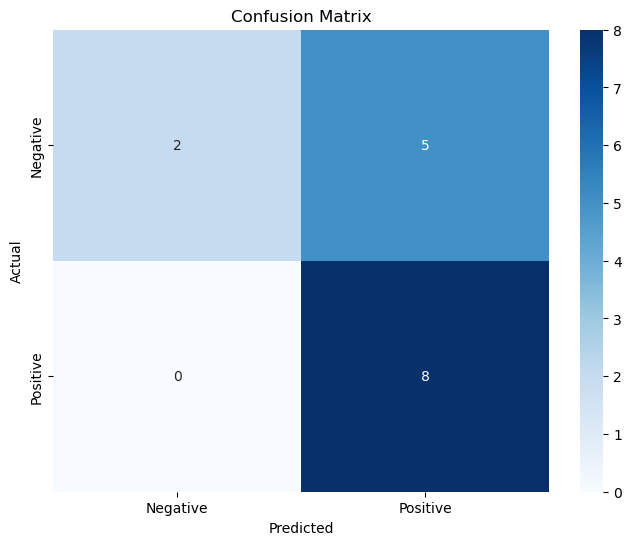

In [10]:
# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()